In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

%matplotlib inline

sns.set(style="whitegrid")

In [47]:
df = pd.read_csv("/Users/iremunal/Desktop/Data_Analysis/RNA_Mutation/METABRIC_RNA_Mutation.csv",low_memory=False)

df.shape

(1904, 693)

In [49]:
df.head()

,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0


In [51]:
df.dtypes.value_counts()

float64    498
object     190
int64        5
Name: count, dtype: int64

In [53]:
missing_ratio = df.isnull().mean().sort_values(ascending=False)

missing_ratio[missing_ratio > 0].head(10)

tumor_stage                  0.263130
3-gene_classifier_subtype    0.107143
primary_tumor_laterality     0.055672
neoplasm_histologic_grade    0.037815
cellularity                  0.028361
mutation_count               0.023634
er_status_measured_by_ihc    0.015756
type_of_breast_surgery       0.011555
tumor_size                   0.010504
cancer_type_detailed         0.007878
dtype: float64

In [55]:
pam50_sub = df["pam50_+_claudin-low_subtype"]
pam50_sub.value_counts(dropna=False)

pam50_+_claudin-low_subtype
LumA           679
LumB           461
Her2           220
claudin-low    199
Basal          199
Normal         140
NC               6
Name: count, dtype: int64

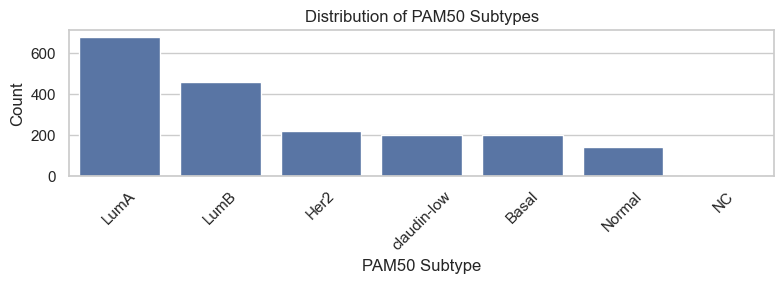

In [57]:
plt.figure(figsize=(8,3))
sns.countplot(x=pam50_sub, data=df, order=pam50_sub.value_counts().index)
plt.title("Distribution of PAM50 Subtypes")
plt.xlabel("PAM50 Subtype")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [59]:
valid_classes = ["LumA", "LumB", "Her2", "Basal"]
df = df[pam50_sub.isin(valid_classes)]

pam50_sub.value_counts()

pam50_+_claudin-low_subtype
LumA           679
LumB           461
Her2           220
claudin-low    199
Basal          199
Normal         140
NC               6
Name: count, dtype: int64

In [61]:
numeric_cols = df.select_dtypes(include=[np.number]).columns

print("Number of numeric (likely RNA) features:", len(numeric_cols))

Number of numeric (likely RNA) features: 503


In [63]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

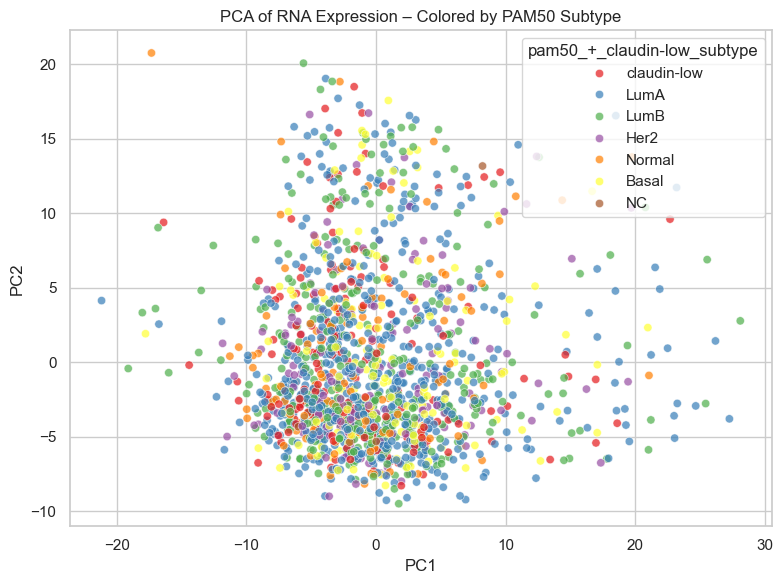

In [65]:
X = df[numeric_cols]
y = pam50_sub

X.isnull().sum().sum()
X = X.fillna(X.mean())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(data=X_pca, columns = ["PC1", "PC2"])
pca_df[pam50_sub] = y.values

plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue=pam50_sub, alpha=0.7, palette="Set1")
plt.title("PCA of RNA Expression – Colored by PAM50 Subtype")
plt.tight_layout()
plt.show()

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [69]:
X = df[numeric_cols].fillna(0)
y = df['pam50_+_claudin-low_subtype']  

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

In [71]:
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

       Basal       1.00      0.82      0.90        40
        Her2       0.87      0.75      0.80        44
        LumA       0.86      0.91      0.88       136
        LumB       0.80      0.84      0.82        92

    accuracy                           0.86       312
   macro avg       0.88      0.83      0.85       312
weighted avg       0.86      0.86      0.86       312

Confusion Matrix:
 [[ 33   4   2   1]
 [  0  33   4   7]
 [  0   1 124  11]
 [  0   0  15  77]]


In [73]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

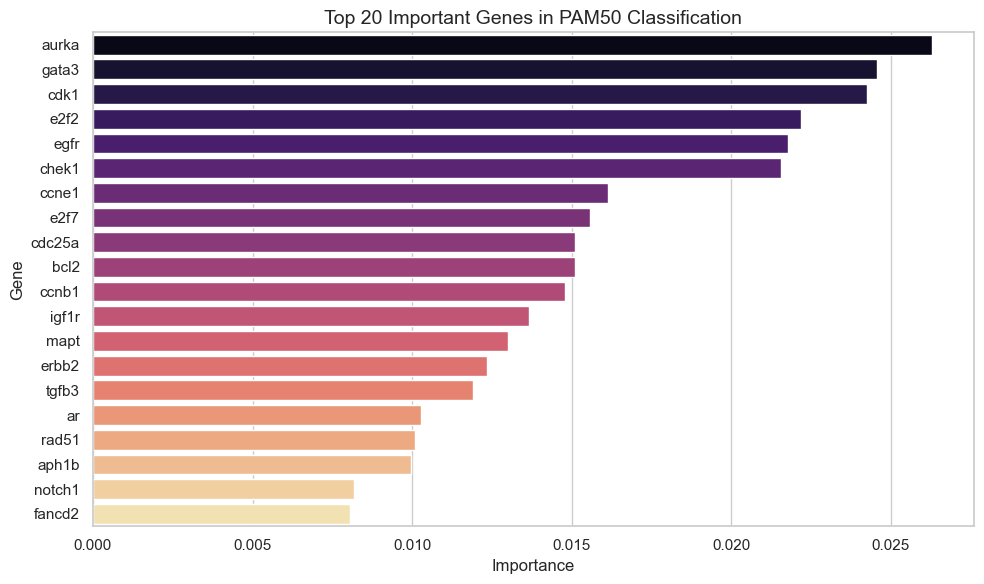

In [75]:
importances = rf.feature_importances_

feature_df = pd.DataFrame({
    'Gene': numeric_cols,
    'Importance': importances
})

feature_df = feature_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=feature_df.head(20), x='Importance', y='Gene', hue='Gene',legend=False, palette='magma')
plt.title("Top 20 Important Genes in PAM50 Classification", fontsize=14)
plt.tight_layout()
plt.show()

In [77]:
from sklearn.manifold import TSNE

In [79]:
np.random.seed(42)
sample_indices = np.random.choice(X_scaled.shape[0], 500, replace=False)
X_sample = X_scaled[sample_indices]
y_sample = y.iloc[sample_indices]

In [83]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=500, random_state=42)
X_tsne = tsne.fit_transform(X_sample)

In [85]:
tsne_df = pd.DataFrame(X_tsne, columns=["TSNE1", "TSNE2"])
tsne_df["Subtype"] = y_sample.values

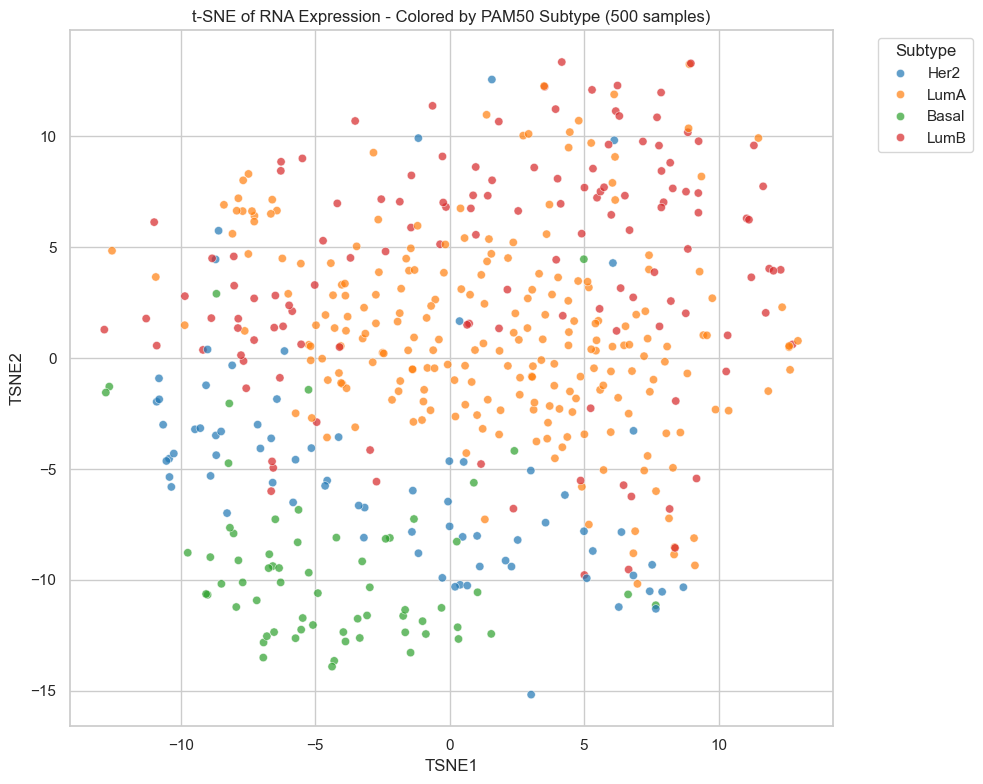

In [87]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=tsne_df, x="TSNE1", y="TSNE2", hue="Subtype", palette="tab10", alpha=0.7)
plt.title("t-SNE of RNA Expression - Colored by PAM50 Subtype (500 samples)")
plt.legend(title="Subtype", bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()

In [89]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay
from itertools import cycle

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [93]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [95]:
y_test_bin = label_binarize(y_test, classes=model.classes_)
y_train_bin = label_binarize(y_train, classes=model.classes_)
n_classes = y_test_bin.shape[1]

In [97]:
classifier = OneVsRestClassifier(RandomForestClassifier(random_state=42))
classifier.fit(X_train, y_train_bin)

OneVsRestClassifier(estimator=RandomForestClassifier(random_state=42))

In [99]:
y_score = classifier.predict_proba(X_test)

In [101]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:,i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [103]:
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'darkred'])

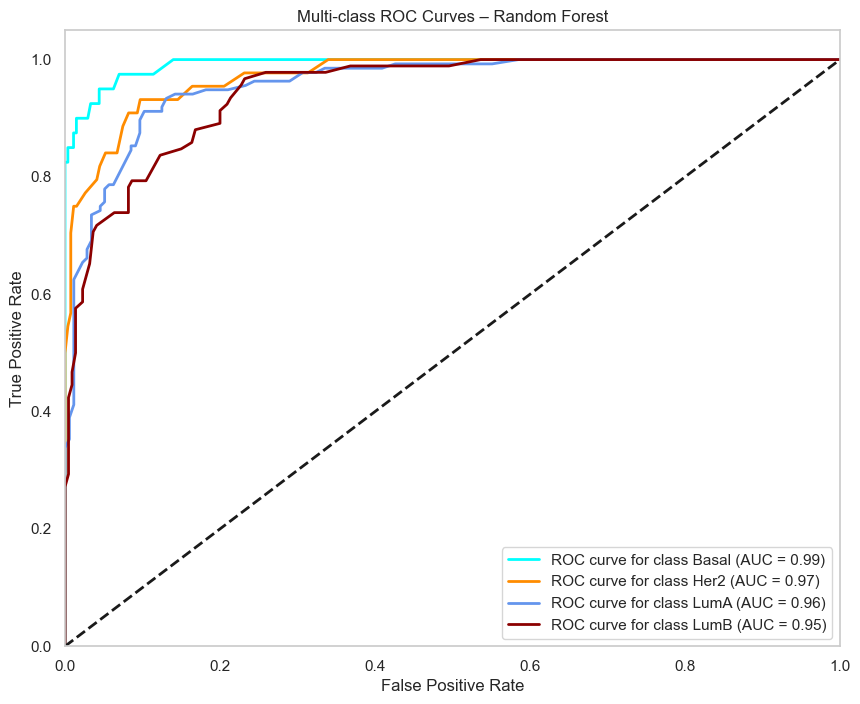

In [105]:
plt.figure(figsize=(10,8))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
            label=f"ROC curve for class {model.classes_[i]} (AUC = {roc_auc[i]:0.2f})")
plt.plot([0,1], [0,1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curves – Random Forest')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [107]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

In [109]:
top_n = 20
top_features = X.columns[indices[:top_n]]
top_importances = importances[indices[:top_n]]

In [111]:
feature_df = pd.DataFrame({
    "Gene": top_features,
    "Importances": top_importances
})

feature_df

,Gene,Importances
0,aurka,0.026299
1,gata3,0.024563
2,cdk1,0.024515
3,e2f2,0.022032
4,chek1,0.021223
5,egfr,0.020660
6,ccne1,0.015944
7,e2f7,0.015727
8,cdc25a,0.015221
9,bcl2,0.015138


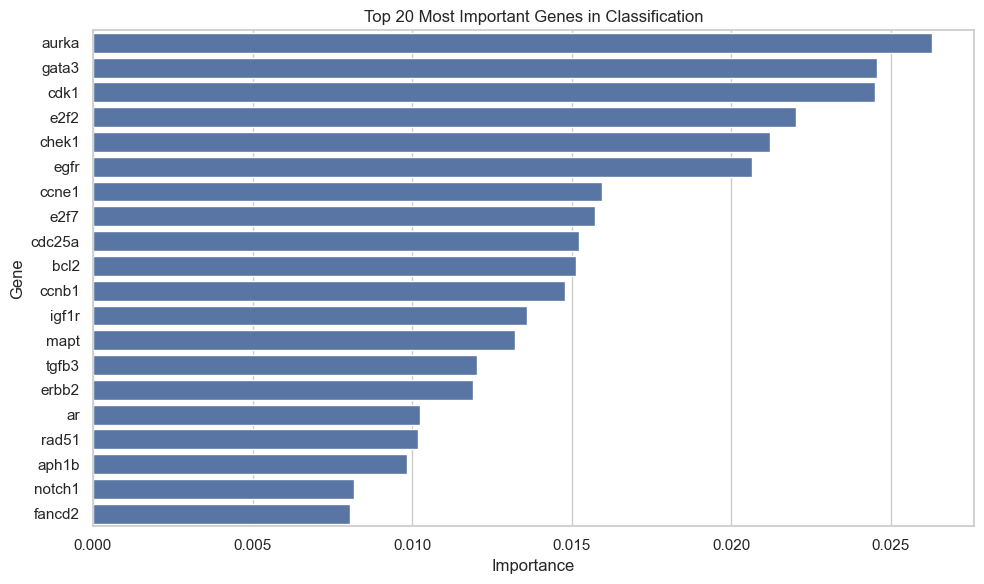

In [113]:
plt.figure(figsize=(10,6))
sns.barplot(data=feature_df, x="Importances", y="Gene")
plt.title("Top 20 Most Important Genes in Classification")
plt.xlabel("Importance")
plt.ylabel("Gene")
plt.tight_layout()
plt.show()

In [115]:
X_top = X[top_features]

In [117]:
X_train_top, X_test_top, y_train, y_test = train_test_split(
    X_top, y, test_size=0.3, random_state=42, stratify=y
)

In [119]:
rf_model_top = RandomForestClassifier(random_state=42)
rf_model_top.fit(X_train_top, y_train)

RandomForestClassifier(random_state=42)

In [121]:
y_pred_top = rf_model_top.predict(X_test_top)

classification_report(y_test, y_pred_top)
confusion_matrix(y_test, y_pred_top)

array([[ 50,   6,   2,   2],
       [  3,  45,   3,  15],
       [  0,   3, 177,  24],
       [  0,   2,  26, 110]])

In [123]:
from sklearn.metrics import classification_report

classification_report(y_test, y_pred_top, target_names=rf_model_top.classes_)

'              precision    recall  f1-score   support\n\n       Basal       0.94      0.83      0.88        60\n        Her2       0.80      0.68      0.74        66\n        LumA       0.85      0.87      0.86       204\n        LumB       0.73      0.80      0.76       138\n\n    accuracy                           0.82       468\n   macro avg       0.83      0.79      0.81       468\nweighted avg       0.82      0.82      0.82       468\n'

In [125]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [129]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)

X_tsne = tsne.fit_transform(X_scaled)

In [131]:
tsne_df = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
tsne_df['Subtype'] = y.values

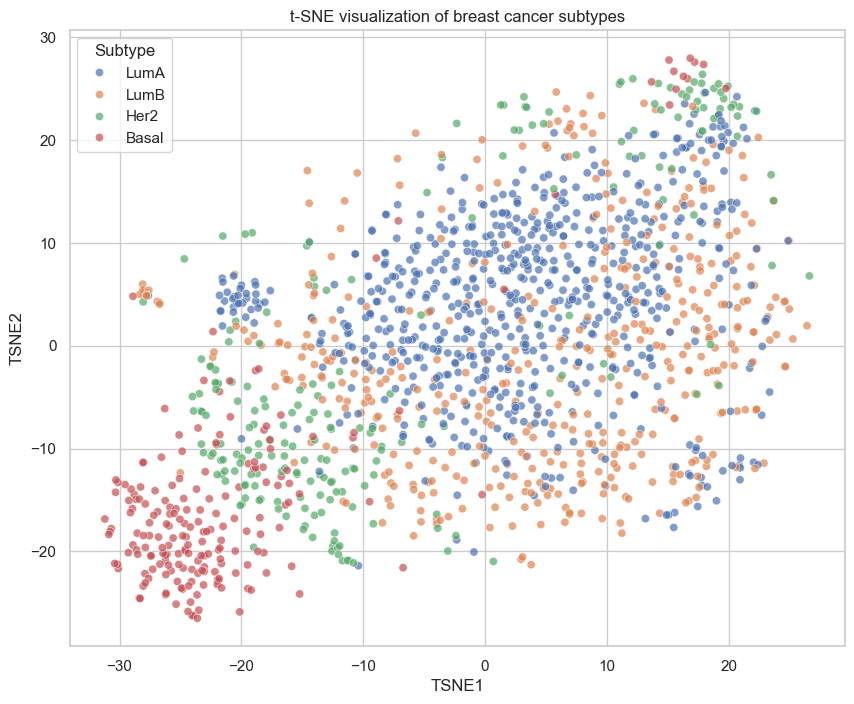

In [133]:
plt.figure(figsize=(10,8))
sns.scatterplot(
    data=tsne_df,
    x='TSNE1',
    y='TSNE2',
    hue='Subtype',
    palette='deep',
    alpha=0.7
)

plt.title('t-SNE visualization of breast cancer subtypes')
plt.legend(title='Subtype')
plt.show()

In [135]:
!pip install umap-learn

In [137]:
!pip uninstall -y umap-learn
!pip install umap-learn==0.5.3

Found existing installation: umap-learn 0.5.3
Uninstalling umap-learn-0.5.3:
  Successfully uninstalled umap-learn-0.5.3
  Using cached umap_learn-0.5.3-py3-none-any.whl


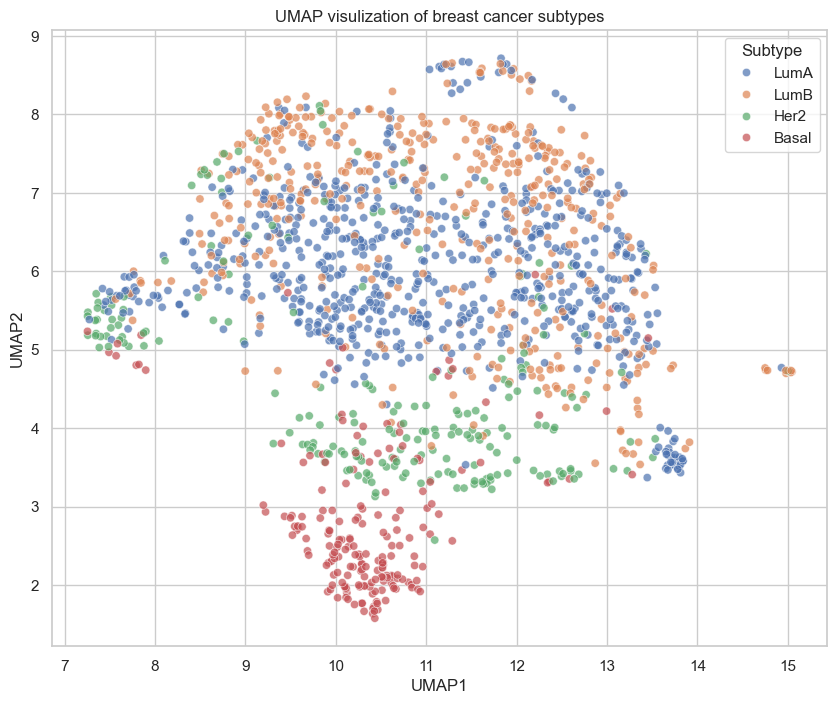

In [139]:
import umap

umap_reducer = umap.UMAP(random_state=42, n_neighbors=15, min_dist=0.1)

umap_embedding = umap_reducer.fit_transform(X_scaled)

umap_df=pd.DataFrame()
umap_df['UMAP1'] = umap_embedding[:,0]
umap_df['UMAP2'] = umap_embedding[:,1]
umap_df['Subtype'] = y.values

plt.figure(figsize=(10,8))
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='Subtype', alpha=0.7, palette='deep')
plt.title('UMAP visulization of breast cancer subtypes')
plt.show()

In [151]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.6/547.6 kB 2.5 MB/s eta 0:00:00-:--:--


In [153]:
import shap
import matplotlib.pyplot as plt

In [191]:
explainer = shap.TreeExplainer(rf_model_top)

In [193]:
shap_values = explainer.shap_values(X_train)

/var/folders/zv/v1v0t9595750wr726xp00nl80000gn/T/ipykernel_22219/3022310071.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train)
/opt/anaconda3/lib/python3.12/site-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/opt/anaconda3/lib/python3.12/site-packages/shap/plots/_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/opt/anaconda3/lib/pyt

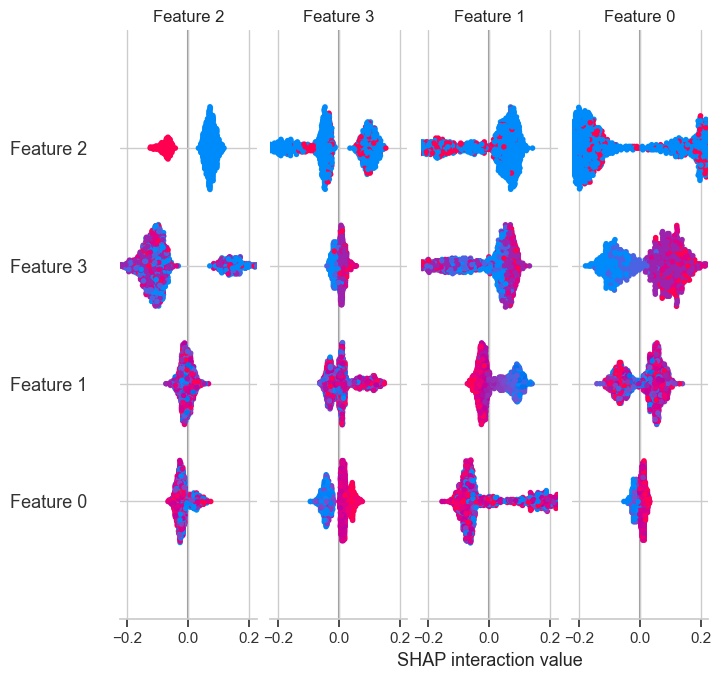

In [194]:
shap.summary_plot(shap_values, X_train)